In [2]:
# import libraries
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import skimage
import skimage.io as skio
from PIL import Image, ImageDraw
import imgaug.augmenters as iaa
import sys
import os
import glob
import gc
import sys
import time


In [3]:
# Load Mask RCNN Library
ROOT_DIR = 'D:/Python/mask_rcnn_aktwelve/Mask_RCNN/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

sys.path.append(ROOT_DIR)
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
# Create Config

class ISICConfig(Config):
    """Configuration for training on the ISICs 2018: Lesion Segmentation dataset.
    Derives from the base Config class and overrides values specific
    to the ISICs 2018: Lesion Segmentation dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'isic_train'

    # Train on 1 GPU and 2 images per GPU. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # 1 (background) + 1 (leison mask)

    # All of our training images are resized to 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Total train images are almost 1500. Set to this number to ensure training of all images.
    STEPS_PER_EPOCH = 1500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 50
    
    # Matterport originally used resnet101, but I adopted akTwelve solution to downsize to fit it on my graphics card
    BACKBONE = 'resnet50' 
    
    IMAGE_RESIZE_MODE = "square"

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56,56)
    
config = ISICConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [5]:
# Define the dataset loader class

class ISICDataset(utils.Dataset):
    '''
    Genenerates keras based dataset for the images and masks
    '''
    
    def load_data(self,masks_dir,images_dir):
        '''
        masks_dir: the folder path of the mask segmentations
        images_dir: the folder path of the images
        '''
        self.masks_dir = masks_dir
        self.images_dir = images_dir
        # Define the filetypes to search for
        img_spec = '*.jpg' # train images
        
        # populate image dictionary
        img_names = []
        for imgfile in os.listdir(images_dir):
            if imgfile.endswith('.png') or imgfile.endswith('.jpg') or imgfile.endswith('.jpeg'):
                
                # get filenames except filetype
                img_names.append(imgfile[:-4])
                image_id = imgfile[:-4]
                image_file_name = imgfile
                
                # save the path location of images
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                
                # add image details to be called by dictionary
                self.add_image(source="isic",
                               image_id=image_id,
                               path=image_path)
                
                # set lesions as class = 1 in dictionary
                self.add_class("isic",1,"leison")
   
    
    def load_mask(self, image_id):
        '''
        image_id: the filename of images to be handles.
        since training image names and segmenation mask image names are similar, we use this.
        '''
        seg_spec = '*.png' # file type of masks
        seg_names = []
        instance_masks = []
        class_ids = []
        image_info = self.image_info[image_id]
        filename = glob.glob(os.path.join(self.masks_dir,image_info['id']+"*"))
        mask_seg = cv2.imread(filename[0],0)
        bool_mask = mask_seg>0
        instance_masks.append(bool_mask)
        class_ids.append(1)
        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids,dtype=np.int32)
        
        return mask, class_ids

In [6]:
# Explicitly define file locations
train_img_path = 'D:/UQ Data Science/Subjects/Semester 4/COMP3710 - Pattern Recognition/Final Report/ISIC2018_Task1-2_Training_Data/Data Split/train_img'
train_seg_path = 'D:/UQ Data Science/Subjects/Semester 4/COMP3710 - Pattern Recognition/Final Report/ISIC2018_Task1-2_Training_Data/Data Split/train_seg'
val_img_path = 'D:/UQ Data Science/Subjects/Semester 4/COMP3710 - Pattern Recognition/Final Report/ISIC2018_Task1-2_Training_Data/Data Split/val_img'
val_seg_path = 'D:/UQ Data Science/Subjects/Semester 4/COMP3710 - Pattern Recognition/Final Report/ISIC2018_Task1-2_Training_Data/Data Split/val_seg'
test_img_path = 'D:/UQ Data Science/Subjects/Semester 4/COMP3710 - Pattern Recognition/Final Report/ISIC2018_Task1-2_Training_Data/Data Split/test_img_full'
test_seg_path = 'D:/UQ Data Science/Subjects/Semester 4/COMP3710 - Pattern Recognition/Final Report/ISIC2018_Task1-2_Training_Data/Data Split/test_seg_full'

# Load dataset using keras
dataset_train = ISICDataset()
dataset_train.load_data(train_seg_path,train_img_path)
dataset_train.prepare()

dataset_val = ISICDataset()
dataset_val.load_data(val_seg_path,val_img_path)
dataset_val.prepare()

dataset_test = ISICDataset()
dataset_test.load_data(test_seg_path,test_img_path)
dataset_test.prepare()

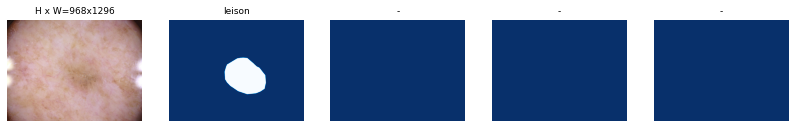

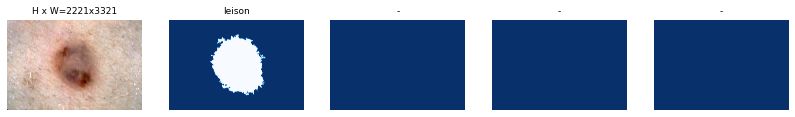

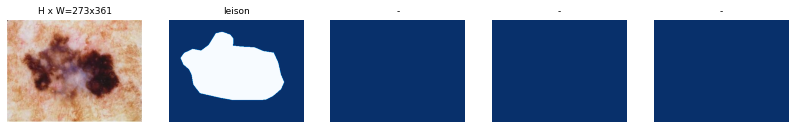

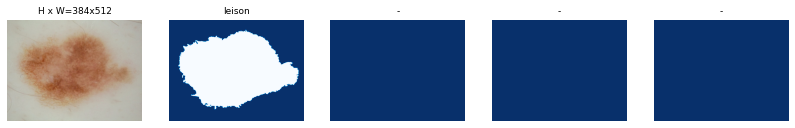

In [7]:
# Visualize if iamges and masks are loaded properly

dataset = dataset_test
image_ids = np.random.choice(dataset.image_ids,4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [8]:
#Generate Model in Training mode
gc.collect()
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
print('model generated')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
model generated


In [10]:
# Load Pre-trained weights
'''
coco: loaded at very beginning of training
last: in-case training is interrupted and need to load previous model saved in memory
specific: in-case python instance is restarted load a specific model from logs folder
'''
# Which weights to start with?
init_with = "coco"  # coco, or last

if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"]
                       )
    print('coco weights loaded')
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

elif init_with == "specific":
    modelh5_path = 'isic_train20211027T1900/mask_rcnn_isic_train_0030.h5'
    model.load_weights(os.path.join(MODEL_DIR,modelh5_path)
                       )
    print('model loaded from',modelh5_path)

coco weights loaded


In [11]:
# Create Augmentation Strategy - Use only non-geometric
augment_strat = iaa.SomeOf((0,None),[
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),
    iaa.WithBrightnessChannels(iaa.Add((-50, 50))),
    iaa.Sharpen(alpha=0.5)
    ])

print('Augmentations Loaded')

Augmentations Loaded


0

In [12]:
# Custom Callback for scheduled learning rate
def scheduler_(epoch, lr = config.LEARNING_RATE):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
custom_callback = keras.callbacks.LearningRateScheduler(scheduler_)  

In [ ]:
# free up some memory before training
gc.collect()

# Training                        
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()

#LAYERS
              # heads: The RPN, classifier and mask heads of the network
              # all: All the layers
              # 3+: Train Resnet stage 3 and up
              # 4+: Train Resnet stage 4 and up
              # 5+: Train Resnet stage 5 and up
            
# my GPU can only handle upto 3+ layer
model.train(dataset_train
            ,dataset_val
            ,learning_rate=config.LEARNING_RATE
            ,epochs=30
            ,layers='3+'
            ,custom_callbacks = [custom_callback]
            ,augmentation = augment_strat
            )

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


In [30]:
# Set model to Inferencing mode
gc.collect()

class InferenceConfig(ISICConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.5

inference_config = InferenceConfig()

In [31]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
print('Inference Mode')

Inference Mode


In [32]:
def load_inference_model(set_path=None):
    '''
    set_path: the path to load a specific model from, else use the current model in memory
    '''
    if set_path != None:
        set_path = set_path
        model_path = os.path.join(ROOT_DIR,set_path)
    else:
        model_path = model.find_last()

    # Load trained weights (fill in path to trained weights here)
    assert model_path != "", "Provide path to trained weights"
    print("Loading weights from ", model_path)
    model.load_weights(model_path, by_name=True)
    
load_inference_model('logs/isic_train20211027T1900/mask_rcnn_isic_train_0010.h5')

Loading weights from  D:/Python/mask_rcnn_aktwelve/Mask_RCNN/logs/isic_train20211027T1900/mask_rcnn_isic_train_0010.h5
Re-starting from epoch 10


Processing 1 images
image                    shape: (1424, 2144, 3)       min:   12.00000  max:  244.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:    0.80784  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 2144.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



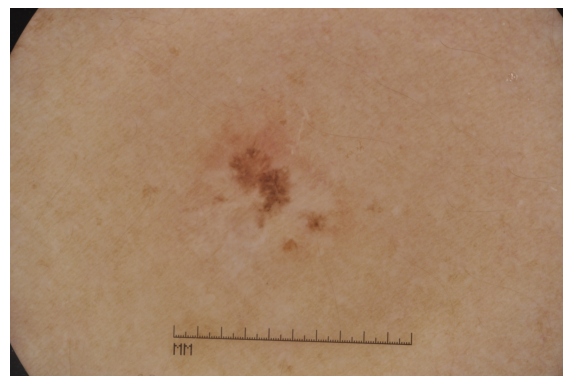

Processing 1 images
image                    shape: (1296, 1936, 3)       min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:    0.96078  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 1936.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



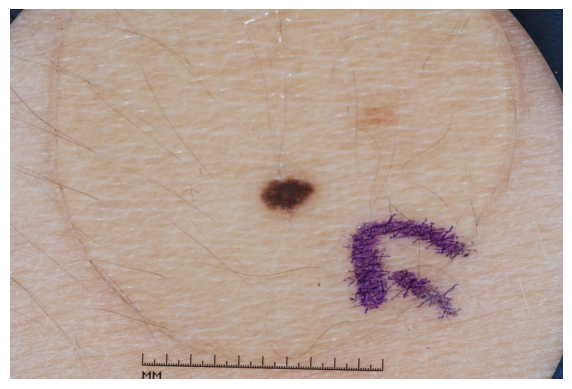

Processing 1 images
image                    shape: (2230, 3344, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:    1.00000  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 3344.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



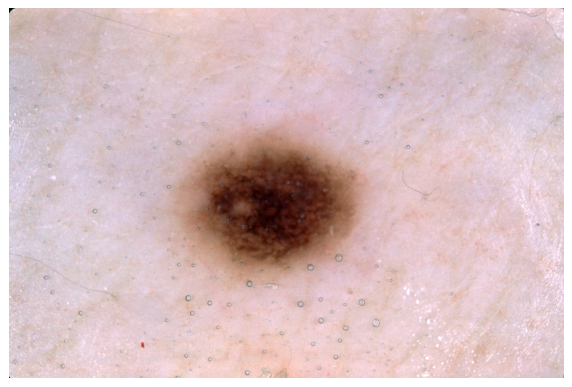

Processing 1 images
image                    shape: (1424, 2144, 3)       min:   15.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:    0.87843  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 2144.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



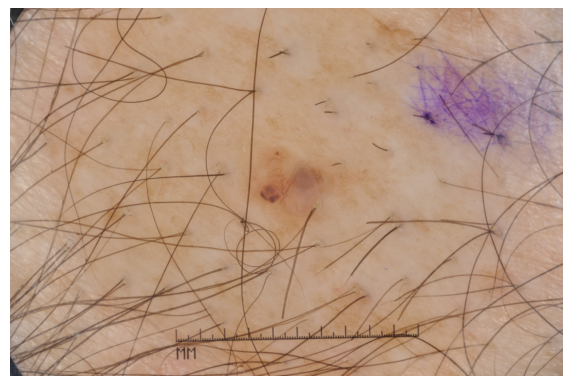

Processing 1 images
image                    shape: (1296, 1936, 3)       min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:    0.96078  float32
image_metas              shape: (1, 14)               min:    0.00000  max: 1936.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32

*** No instances to display *** 



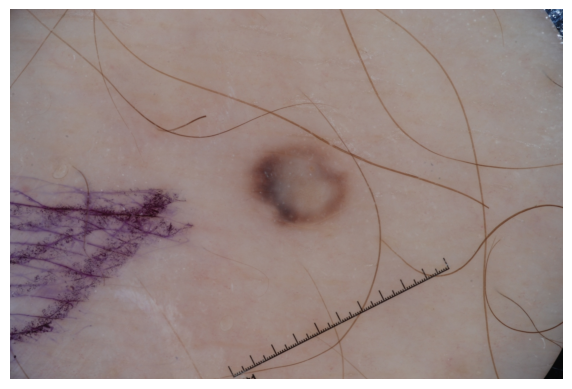

In [33]:
# Visualize Predictions on the image - takes longer for higher resolution images

# define the test folder
real_test_dir = 'D:/UQ Data Science/Subjects/Semester 4/COMP3710 - Pattern Recognition/Final Report/ISIC2018_Task1-2_Training_Data/Data Split/test_img_full'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

# select some images to visualize
images = np.random.choice(image_paths,5,replace=False)

for image_path in images:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    
    # use the visualize.py from mrcnn folder to show results
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], figsize=(10,15))
    

In [ ]:
'''
Calculate the following:
    Intersetion over Union (IoU) per image
    mean Average Precision (mAP) @ IoU threshold 80%.
        This will return the Average Precision across all images, and only include IoU image scores >= 0.8
    mean Precision @ IoU threshold 80%. This will return mean of all precisions of objects per image
    mean Recalls @ IoU threshold 80%. This will return the 
    
'''

dataset = dataset_test
iou_threshold=0.80
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    precisions_all = []
    recall_all = []
    iou_all = []

    for image_id in image_ids:

        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, inference_config, image_id)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        res_mask = utils.minimize_mask(r['rois'],r['masks'],config.MINI_MASK_SHAPE)
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], res_mask,iou_threshold=iou_threshold)
        APs.append(AP)
        precisions_all.append(np.mean(precisions))
        recall_all.append(np.mean(recalls))
        
        # overlaps == IoU. ensure that all IoU scores are included (regardless if there is no object detected)
        if np.size(overlaps) == 0:
            iou_all.append(0)
        else:
            iou_all.append(np.max(overlaps))
        
        
    return APs, precisions_all, recall_all, iou_all

# Calculate for the whole dataset
image_ids = dataset.image_ids
APs, precisions, recalls, ious = compute_batch_ap(image_ids)
print("mAP @IoU="+str(iou_threshold)+": ", np.round(np.mean(APs),4))
print("mean Precisions @IoU="+str(iou_threshold)+": ", np.round(np.mean(precisions),4))
print("mean Recalls @IoU="+str(iou_threshold)+": ", np.round(np.mean(recalls),4))
print("model IoU:", np.round(np.mean(ious),4))